# Transfer Learning Challenge

Use a pre-trained deep learning vision model to predict [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

## Approach

The [STL-10 dataset](http://cs.stanford.edu/~acoates/stl10/) consists of 5,000 training images and 8,000 test images that are 96 by 96 with three color channels selected from the [ImageNet](http://www.image-net.org/) dataset. (It also includes 100,000 unlabeled images to be used for unsupervised learning, but I won't be using those.) There are an equal number of images in each of 10 classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck) for both the train (500) and test (800) sets.

The challenge is to use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to create a model that predicts the classes as accurately as possible on the test set as a whole. It appears that the state of the art today is 78.66% accuracy. ([This site](https://martin-thoma.com/sota/), updated as of 2017-02, had a good list of top results for many standard datasets.) But that accuracy figure is for a different protocol than the one that I'm going to execute. That protocol entailed performing unsupervised learning on the unlabeled training images and then supervised learning on the labeled data using 10 pre-defined folds, each containing 1,000 images with the overall accuracy then reported as the average of the ten separately trained models. 

I'm going to train on all 5,000 training images, and instead of using the unlabeled images, I'm going to use weights from the pretrained [Resnet50 model](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) included with [Pytorch](http://pytorch.org/docs/master/index.html) for transfer learning. Since Resnet50 was trained on the ImageNet dataset, the results should be excellent. I checked around the internet and found other results in the mid-90%'s using a similar approach.

## Setup

### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, time, math
from tqdm import tnrange, tqdm_notebook
from PIL import Image

### Specify data transforms

Here we set up the transforms. The means and standard deviations are those from the ImageNet dataset. We want to normalize our images using these so that normalization is consistent with the distribution of the images used to train the transfer learning model. The other thing that is important is to set the image size, below using `transforms.Resize`, to the size of the images the transfer learning model is expecting, in this case 224 x 224.

For the training set, I use various transformations in order to achieve the effect of augmentation as mini-batches are generated. First I pad the images and select a random crop to get some variability in object placement within the images followed by a random rotation of up to five degrees and lastly, a random horizontal flip.

In [2]:
means, stds = (np.array(x) for x in ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(96),
        transforms.Resize(224),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)]),
    'disp': transforms.Lambda(lambda x: x)}

### Instantiate datasets

Pytorch has several popular [datasets](http://pytorch.org/docs/master/torchvision/datasets.html) available directly from its API, including the [STL10 dataset](https://github.com/pytorch/vision/blob/master/torchvision/datasets/stl10.py). I needed the indices of the images from the dataloaders to be able to view the images associated with predictions from the model, the Pytorch dataset didn't return smaller images for displaying and it reloaded all of the datasets, including two with all of the unlabeled images, every time the notebook ran, which was slow, so I wrote the one below.

In [35]:
class STL10(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split if split == 'train' else 'test'
        self.transform = transform
        
        with open(os.path.join(self.root_dir, '{}_X.bin'.format(self.split)), 'rb') as f:
            data = np.fromfile(f, dtype=np.uint8)
            images = np.reshape(data, (-1, 3, 96, 96))
            self.images = np.transpose(images, (0, 3, 2, 1))
        
        with open(os.path.join(self.root_dir, '{}_y.bin'.format(self.split)), 'rb') as f:
            # subtract 1 to be zero based
            self.labels = np.fromfile(f, dtype=np.uint8).astype(np.int64) - 1
            
        with open(os.path.join(self.root_dir, 'class_names.txt')) as f:
            self.classes = f.read().splitlines()
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        with open(os.path.join(self.root_dir, '{}_X.bin'.format(self.split)), 'rb') as f:
            image = Image.fromarray(self.images[idx])
            
            if self.transform:
                image = self.transform(image)
                
            return image, self.labels[idx], idx

In [36]:
root_dir = 'stl10_binary'
ds={x: STL10(root_dir, x, data_transforms[x]) for x in ['train', 'test', 'disp']}

### Instantiate data loaders

Here we set up the data loaders, which are iterators that feed batches of data in to the training loop. I made sure the batch size was small enough to fit in memory on my machine.

In [37]:
bs = 64
dl = {'train': DataLoader(ds['train'], bs, True, num_workers=6),
      'test': DataLoader(ds['test'], bs, False, num_workers=6)}

### Examine images

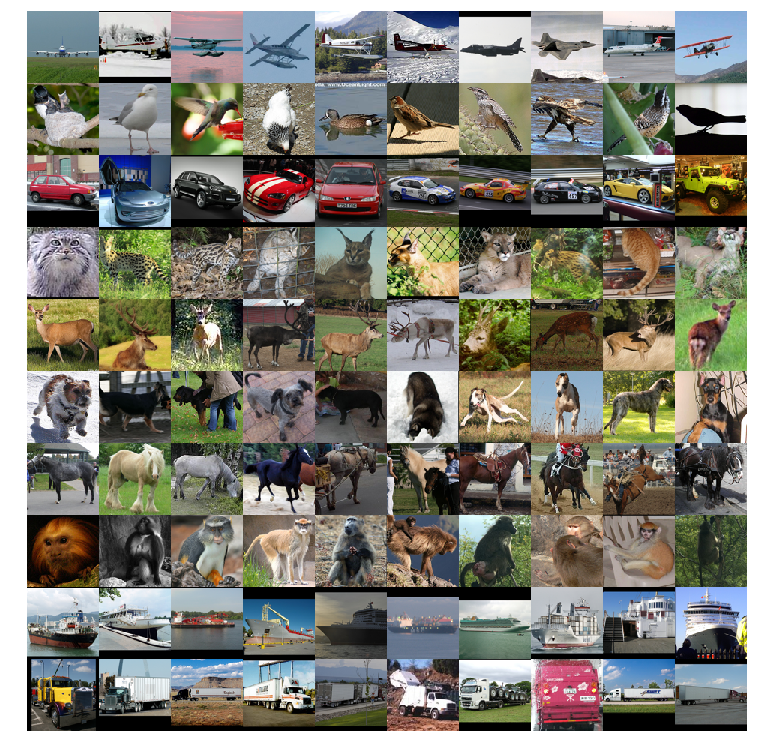

In [38]:
np.random.seed(1)
rows, cols = 10, 10
fig = plt.figure(figsize=(rows, cols))
gs = gridspec.GridSpec(rows, cols, width_ratios=[1] * cols,
         wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=1.0) 

for r in range(rows):
    idxs = np.random.choice(np.argwhere(ds['disp'].labels == r).flatten(), (rows,))
    for c, idx in enumerate(idxs):
        ax = plt.subplot(gs[r,c])
        ax.imshow(ds['disp'][idx][0])
        ax.axis('off')
        
plt.show()

Before moving on to the model, let's take a quick look at some of the test images.

It looks like the images are pretty well defined, although there do appear to be a few challening ones interspersed throughout. The cat in the fourth row and ninth column, for example, doesn't have the cat's head in it. The dog image in the sixth row and third column is mostly of a person's legs. The truck image in the last row and and eighth column is pretty close up and just of the rear of the truck. However, if there were a sufficient number of similar images in the dataset the transfer learning model was trained on, these issues shouldn't affect accuracy.

The grid is set up to pull images in from each class (in the rows) randomly, so you can look at a bunch of different images by commenting out the random seed and re-running.

## Training loop

This is pretty straightforwad, starting with the [Pytorch Transfer Learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). You basically feed in a model, a criterion (loss function), an optimization algorithm, and a number of epochs and get back the model that had the lowest loss on the test set from any of the epochs. For each epoch, it loops through the batches for both the training and test sets (only performing back propogation for the training set) and then updates the weights for the next batch. I added in some logic to store the indices, predictions and class probabilities for the test set in a data frame so that they could be analyzed after training. I also added in some [progress bars](https://github.com/noamraph/tqdm).

I was running on an [Nvidia P5000 GPU](http://images.nvidia.com/content/pdf/quadro/data-sheets/192195-DS-NV-Quadro-P5000-US-12Sept-NV-FNL-WEB.pdf) at [Paperspace](https://www.paperspace.com/ml), which was cooking right along, but kept the cpu-only code so that it works without a gpu.

It seemed somewhat inefficient to run the predictions on the full 8,000 image test set with each epoch, but I left it as is since the model was training for so few epochs. It would have also been nice to have had separate development and test sets, but the accuracy of the model was so good, there wasn't a lot of development to be done.

In [7]:
class_names = ds['train'].classes
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, hide_pbars=True):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    phases = ['train', 'test']
    
    # set up tensor for storing prediction outputs from best epoch
    columns = list(range(len(class_names))) + ['idx', 'pred', 'label']
    preds_best = torch.FloatTensor()
    
    # set up tensor for storing training and test losses
    mbs_train = math.ceil(len(ds['train'])/bs)
    loss_history = {x: np.zeros(num_epochs*mbs_train) for x in phases}
    
    if use_gpu:
        preds_best.cuda()
    
    for epoch in tnrange(num_epochs, desc='epochs:', disable=hide_pbars):
        if not(hide_pbars):
            print('-'*10)
            print('epoch {}/{}:'.format(epoch + 1, num_epochs))
        
        for phase in phases:
            if phase == 'train':
                model.train(True)
                scheduler.step()
            else:
                model.train(False)
                
                # set up tensor for storing prediction outputs from batch
                preds_e = torch.zeros(len(ds['test']), len(columns))
                if use_gpu:
                    preds_e = preds_e.cuda()

            running_loss = 0.0
            running_corrects = 0
            running_m = 0

            for b, data in enumerate(tqdm_notebook(
                dl[phase], desc=phase+":",leave=False, disable=hide_pbars)):
                inputs, labels, idxs = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    idxs = idxs.cuda()
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # update prediction outputs
                running_m += len(idxs)
                if phase == 'test':
                    preds_e_idx = slice(running_m-len(preds), running_m)
                    preds_e[preds_e_idx,:len(class_names)] = outputs.data
                    for t, t1d in enumerate((idxs, preds, labels.data)):
                        preds_e[preds_e_idx,len(class_names) + t] = t1d

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    lh_idx = epoch * mbs_train  + b
                    loss_history[phase][lh_idx] = running_corrects / running_m
                
            epoch_loss = running_loss / len(ds[phase])
            epoch_acc = running_corrects / len(ds[phase])
            
            if not(hide_pbars):
                print('{:>7}--> loss: {:6.4f} acc: {:6.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'test':
                loss_history[phase][(epoch + 1) * mbs_train - 1] = epoch_acc
                
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                preds_best = preds_e
                
    time_elapsed = time.time() - since
    print('-'*10)
    print('training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('best test acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()
    
    # create dataframe of prediction outputs with probabilites
    e = torch.exp(preds_best[:, :len(class_names)]) 
    preds_best[:, :len(class_names)] = e / torch.sum(e, 1).view(len(ds['test']), 1)
    
    if use_gpu:
        preds_best = preds_best.cpu()
        
    df_preds = pd.DataFrame(preds_best.numpy(), columns=columns).set_index('idx')
    df_preds.index = df_preds.index.astype(int)
    for col in ['pred', 'label']:
        df_preds[col] = df_preds[col].astype(int)
        df_preds['{}_cl'.format(col)] = df_preds[col].apply(lambda x: class_names[int(x)])
    df_preds['incorrect'] = df_preds.label != df_preds.pred
    
    df_lh = pd.DataFrame(loss_history)
    df_lh.test[df_lh.test == 0] = None
    
    return model, df_preds, df_lh

## Model

I decided to use the [Resnet50](https://arxiv.org/abs/1512.03385) model since it was trained on the ImageNet data set (the same set the STL10 dataset was pulled from) and had great results in the literature. It can be loaded directly from Pytorch's api (along with several other popular models, docs [here](http://pytorch.org/docs/0.3.0/torchvision/models.html?highlight=models)).

We need to indicate that we want to use the pretrained weights and then replace the last fully connected layer with a new one with the dimensions of our dataset. You can get the number of features being fed in to a layer with `.in_features`. I won't print it out here in the interest of brevity, but you can get a summary of the model with the keys of the layers with `print(model)`. In the case of Resnet50, the last fully connected layer has a key of `fc`. The new layer needs to have the same number of features being fed into it as the original one, but with ten output features to correspond to our dataset, instead of the 1,000 in the original ImageNet dataset.

I stuck with cross entropy for the loss function and vanilla stochastic gradient descent for the optimizer.

In [8]:
model = models.resnet50(pretrained=True)
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, len(ds['train'].classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_gpu:
    model = model.cuda()

## Train

Here, we train the model for 15 epochs. The chart below plots the average accuracy as the training loop steps through mini-batches and the accuracy on the test set after each epoch.

In [9]:
model, df_preds, loss_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=15, hide_pbars=True)
torch.save(model, 'model')

----------
training complete in 15m 32s
best test acc: 0.978125


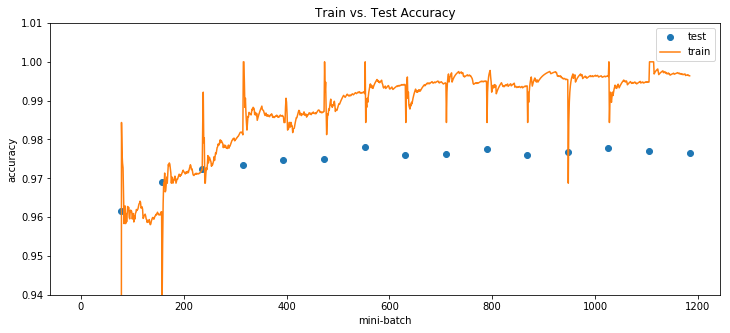

In [10]:
fig = plt.figure(figsize=(12, 5))
plt.plot(loss_history['test'], marker='o', linestyle='', label='test')
plt.plot(loss_history['train'], label='train')
plt.ylim([0.94, 1.01])
plt.title('Train vs. Test Accuracy')
plt.xlabel('mini-batch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Evaluate

Overall these are terrific results, with **97.8%** accuracy (recall). The best model was generated on the 8th epoch and thereafer the model looks like it was starting to over fit.

In [11]:
print(classification_report(df_preds.label, df_preds.pred,
                            target_names=class_names, digits=3))

             precision    recall  f1-score   support

   airplane      0.992     0.983     0.987       800
       bird      0.991     0.984     0.987       800
        car      0.984     0.986     0.985       800
        cat      0.966     0.958     0.962       800
       deer      0.970     0.966     0.968       800
        dog      0.956     0.973     0.964       800
      horse      0.980     0.971     0.976       800
     monkey      0.984     0.988     0.986       800
       ship      0.985     0.995     0.990       800
      truck      0.974     0.979     0.976       800

avg / total      0.978     0.978     0.978      8000



## Analyze

### Incorrect classifications

It looks like our best class was ship, with only four incorrectly classified images, and our worst was cat, with 34 incorrectly classified images. In total 7,825 were classified correctly and 175 incorrectly.

In [22]:
pd.DataFrame(df_preds.groupby(['label_cl'])
             .sum()['incorrect'].sort_values(ascending=True).astype(int))

,incorrect
label_cl,
ship,4
monkey,10
car,11
bird,13
airplane,14
truck,17
dog,22
horse,23
deer,27


### Confusion matrix

From the confusion matrix below we can tell that the incorrectly classifed ship images were either classifed as truck or airplane, which intuitively makes sense since airplanes and trucks are the most similar in appearance to ships relative to the other classifications. The incorrect cat classifications are distributed more widely, across, deer, horse and monkey. Deer, our second worst class is an interesting one: it seems odd that so many of the misclassifications were as cats.

In [13]:
df_preds.groupby(['label_cl', 'pred_cl']).count()[0].unstack('pred_cl').fillna(0).astype(int)

pred_cl,airplane,bird,car,cat,deer,dog,horse,monkey,ship,truck
label_cl,,,,,,,,,,
airplane,786,0,2,0,0,0,0,0,6,6
bird,1,787,0,6,1,2,0,3,0,0
car,1,0,789,0,0,0,0,0,0,10
cat,0,0,0,766,10,17,0,7,0,0
deer,0,2,0,10,773,3,10,2,0,0
dog,0,2,0,9,4,778,6,1,0,0
horse,0,3,1,0,5,11,777,0,0,3
monkey,0,0,0,2,4,3,0,790,1,0
ship,2,0,0,0,0,0,0,0,796,2


### Review misclassified images

#### Ship

In [14]:
def imshow_preds(idxs):
    cols = len(idxs)
    
    fig = plt.figure(figsize=(5*cols,0.8*cols))
    
    for c, idx in enumerate(idxs):
        ax = fig.add_subplot(1, cols, c+1)
        ax.axis('off')
        ax.imshow(ds['disp'][idx][0])

        iop = df_preds.iloc[idx]
        pred_score = iop[iop.pred]
        label_score = iop[iop.label]
        pred_title = '{:>5} {:4} {:.3f}'.format('pred:', class_names[iop.pred][:4], pred_score)
        label_title = '{:>5} {:4} {:.3f}'.format('label:', class_names[iop.label][:4], label_score)
        plt.title('idx: {}\n{}\n{}'.format(idx, label_title, pred_title), fontsize=18*cols/5.)
    
    plt.show()

In [15]:
def get_idxs(class_name):
    idxs = df_preds[(df_preds.label_cl == class_name) & (df_preds.incorrect == True)]
    idxs = idxs.sort_values(class_names.index(class_name))
    return list(idxs.index.astype(int))[:5]

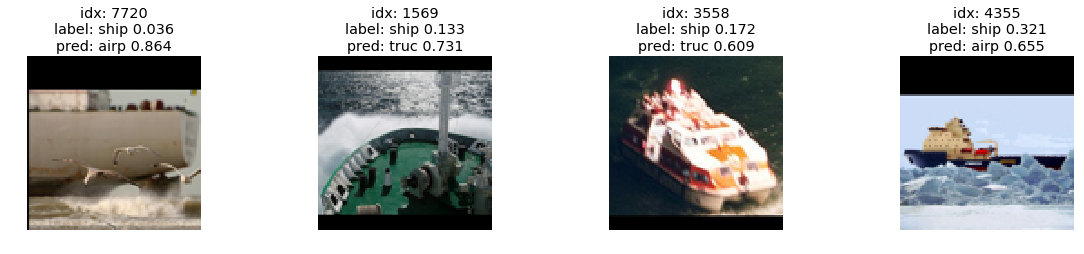

In [16]:
imshow_preds(get_idxs('ship'))

Let's take a look at some of the incorrectly classified images, starting with the four  ship images. Each appear to have aspects that make them challenging to classify. The first is zoomed in, is a little blurry and happens to have some birds in it (that have wings like airplanes do). The third one is blurry and the contrast appears dark so the water is hard to distinguish. The last one has conspicuous icebergs in it that could be perceived as similar to clouds.

The title on the images shows the index in the dataset, the correct label with probability for that label and the predicted class with probability. The images are sorted with the most incorrect furthest to the left.

#### Deer

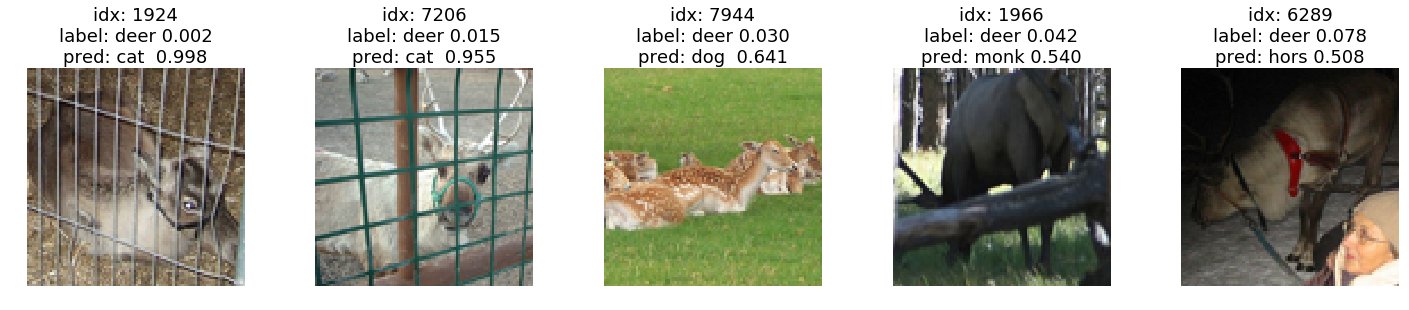

In [17]:
imshow_preds(get_idxs('deer'))

The deer images with the lowest score for deer also appear to have some challenging aspects to them. The third could be perceived as being more similar to a dog given that the deer are so close to the ground and you can't see their long, deer-like legs. The fourth one is really dark and actually does look like a monkey at first glance.

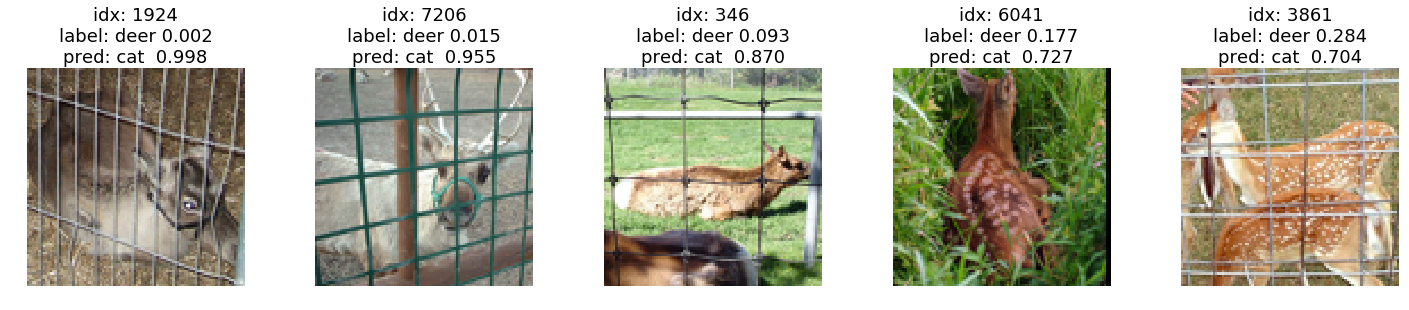

In [18]:
idxs = df_preds[(df_preds.label_cl == 'deer') & (df_preds.incorrect == True)]
idxs = idxs.sort_values(class_names.index('cat'), ascending=False)
idxs = list(idxs.index.astype(int))[:5]
imshow_preds(idxs)

Since cat was on of the most common misclassification for deer, let's take a look at the misclassifed deer images with the highest scores for cat. It's interesting that four of these images have some kind of meshed fence in them.

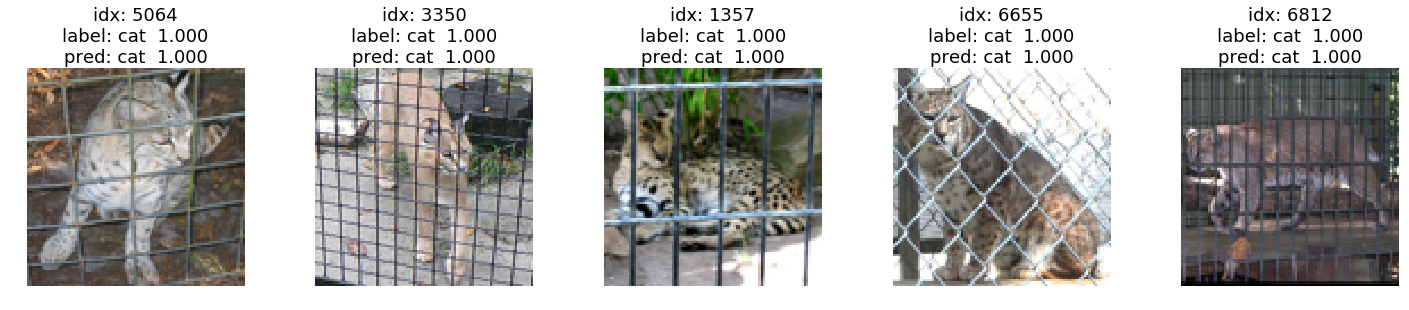

In [19]:
idxs = df_preds[(df_preds.label_cl == 'cat') & (df_preds.incorrect == False)]
idxs = idxs.sort_values(class_names.index('cat'), ascending=False)
idxs = list(idxs.index.astype(int))[:5]
imshow_preds(idxs)

Let's take a look at the cat pictures with the highest scores for cat to see whether they also have some sort of grid in them. Sure enough, there must have been a lot of images of 'cats' taken at zoos that were in cages and that is what is causing the model to key in on the cages or fences in the deer pictures. I'm curious how you would deal with that from a model perspective, whether it is possible to determine how the 'cage' feature was manifested in the layers of the model and adjust for it.

#### Cat

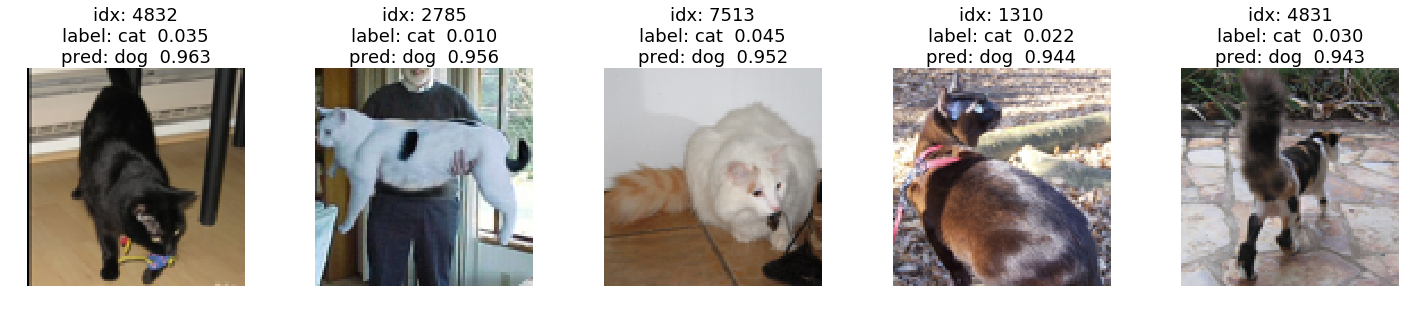

In [23]:
def mis_cats(mis):
    idxs = df_preds[(df_preds.label_cl == 'cat') & (df_preds.incorrect == True)]
    idxs = idxs.sort_values(class_names.index(mis), ascending=False)
    idxs = list(idxs.index.astype(int))[:5]
    imshow_preds(idxs)
mis_cats('dog')

Here are the cat images with the highest dog probabilities. I don't see anything in particular in common in these images to explain why they were classified as dogs.

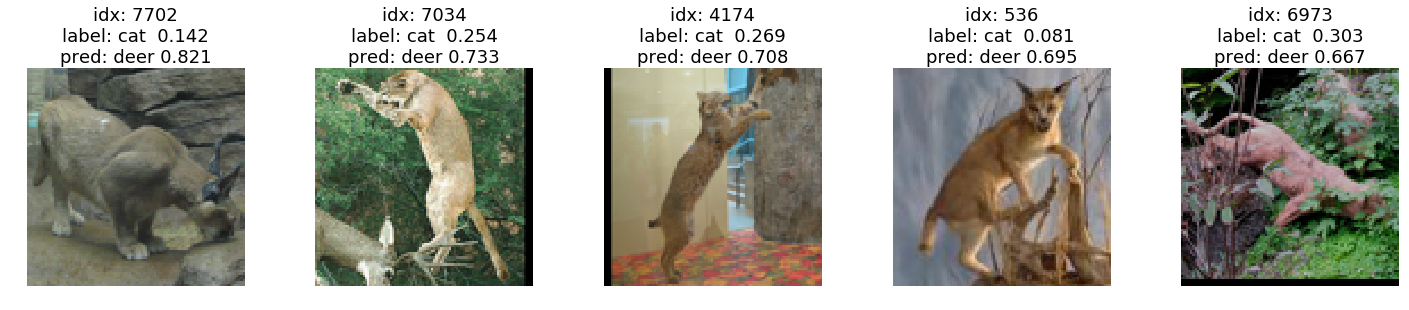

In [20]:
def mis_cats(mis):
    idxs = df_preds[(df_preds.label_cl == 'cat') & (df_preds.incorrect == True)]
    idxs = idxs.sort_values(class_names.index(mis), ascending=False)
    idxs = list(idxs.index.astype(int))[:5]
    imshow_preds(idxs)
mis_cats('deer')

Here are the cats with the highest deer probabilities. It looks like the deer like color ened up being more significant than the cat like shapes.

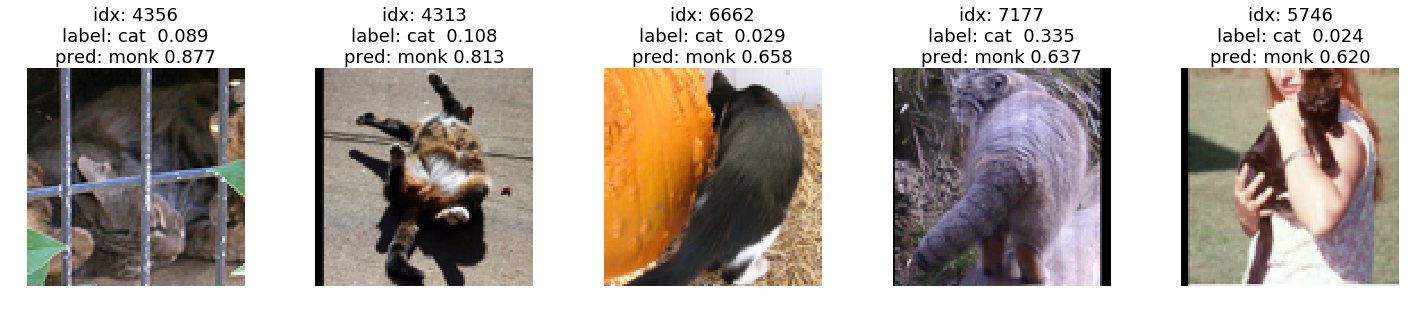

In [24]:
def mis_cats(mis):
    idxs = df_preds[(df_preds.label_cl == 'cat') & (df_preds.incorrect == True)]
    idxs = idxs.sort_values(class_names.index(mis), ascending=False)
    idxs = list(idxs.index.astype(int))[:5]
    imshow_preds(idxs)
mis_cats('monkey')

Here are the cats with the highest monkey probabilities. It looks like the color may have ended up being more significant than the shapes again.

## Conclusion

Transfer learning based on the Resnet50 model produced excellent results in classifying images in the STL10 dataset. I was impressed with absolute results of nearly 98%. However, part of the explanation for the great results is that the STL10 images are a subset of the ImageNet images that the Resnet50 model was trained on. We are testing on images the model was trained on.

Working through the images after the model was trained was very insightful. By analyzing a few different buckets of images, I was able to develop some intuitions about how the model makes predictions, highlighting the mechanics of convolutional networks in general.

Convolutional networks, in essence, identify features and then aggregagte them through the layers of their architecture. They have proven to be exceptionally good at this task. However, the construct of a multi-classification problem and the fact that the networks don't consider important information that humans consider in classifying images leave room for improvement.

Many images actually have more than one object in them. Yet the classification problem fed into the network only identifies a single object. In many respects the vector of classification probabilities produced by the model is a much better representation of the content of an image than the single label. Take for example the first misclassified ship image. There is a ship in it, but also several birds. Only a portion of the ship is visible, but most of the birds are visible, and each has two wings, for a total of six wings in the image. In this case the convolutional network likely determined that the wings were more important than the partial ship and classified the image as an airplane (with a probability of 86% verus just 4% for the ship). The network is actually relaying back an important insight, which is that birds are similar to airplanes, but that is lost in the construct of the mutliclassification problem with only a single possible label.

Another potential problem arises when images from different classifications share features, even when those features are irrelevant to the classification problem from a human perspective. The phenomenon with the deer images being classified as cats is a perfect example. A human knows that the fence is not the subject of the images, but the convolutional network learns those features from the cat images and then uses them in its classification decisions.

Lastly, convolutional networks miss important information regarding real world size and spatial relationships. Convolutional networks aren't able to determine whether a close-up image of a cat is a different real world size than a far way image of a super tanker. Humans use this universal perspective on the world to make classifications. It is interesting to think about how convolutional architectures might be evolved to consider additional information that would improve their ability to predict classifications. I'm fascinated by the idea of [capsule](https://openreview.net/pdf?id=HJWLfGWRb) models, which as I understand it attempt to incorporate additional spatial relationship information into their arhcitectures. I'm also curious about how all of the meta information that digital cameras capture today and the three dimensional data augmented reality capable cameras capture could be utilized to improve performance.

#### tl;dr
I've completed Andrew Ng's original [Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning), his more recent [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) and the first two lectures of the [fast.ai deep learning course](http://course.fast.ai/). I've also completed a couple of projects building and operationalizing models in the auto insurance space, but still consider myself fairly new to deep learning. I've used [Tensorflow](https://www.tensorflow.org/), [Keras](https://keras.io/) and the [scikit-learn](http://scikit-learn.org/stable/) before so I decided to tackle this challenge with [Pytorch](http://pytorch.org/).

I ended up really liking Pytorch. The process of constructing the Dataloader class and learning about how the training loop and model worked was valuable. There were a bunch of times where I was tracking down errors and appreciated that they referred to lines in my notebook that I could trace directly. The documentation was excellent. I like how tensors are moved explicitly on and off the gpu. I liked the mental model of thinking of it as something like numpy with gpu capabilities and a differntiation engine. ([This talk](https://www.youtube.com/watch?v=LAMwEJZqesU) by Souminth Chintala, one of the developers, was an excellent orientation.) Overall, even though it is more hands on than Keras, I found it easier to pick up since the mechanics seem to be closer to the theoretical constructs I've learned in the courses and readings.